<a href="https://colab.research.google.com/github/FilippMaksimov/SPbSU.NLP/blob/main/Maksimov_HW2_banki_sent_vocab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip uninstall numpy -y

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [ ]:
!pip install numpy==1.26.4 --no-deps

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [ ]:
import numpy as np

np.version.full_version

'1.26.4'

#  Домашнее задание по NLP # 2 [100 баллов]
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  



Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [ ]:
import re
import json
import bz2
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords

nltk.download('stopwords')

# Инициализация
mystem = Mystem()
russian_stopwords = stopwords.words('russian') + ['это', 'весь', 'который']

def preprocess_text(text):
    # Удаление спецсимволов и чисел
    text = re.sub(r'[^а-яА-ЯёЁ]', ' ', text.lower())
    # Лемматизация
    lemmas = mystem.lemmatize(text)
    # Удаление стоп-слов и коротких токенов
    tokens = [lemma.strip() for lemma in lemmas if lemma.strip() and lemma not in russian_stopwords]
    return ' '.join(tokens)

# Загрузка и обработка данных
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as file:
    for row in tqdm(file):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and resp['text'].strip():
            resp['processed_text'] = preprocess_text(resp['text'])
            responses.append(resp)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
201030it [48:03, 69.72it/s] 


In [ ]:
!pip install gensim

In [ ]:
from gensim.models import Word2Vec

sentences = [resp['processed_text'].split() for resp in responses]

model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    epochs=30
)

In [ ]:
# Тест на ближайшие слова
print("Ближайшие к 'хороший':", model.wv.most_similar('хороший', topn=5))

# Тест на аналогии (мужчина-король : женщина-королева)
print("Аналогия:", model.wv.most_similar(positive=['женщина', 'король'], negative=['мужчина']))

# Тест на лишнее слово
print("Лишнее слово:", model.wv.doesnt_match(['очередь', 'медленно', 'быстрый', 'проблема']))

Ближайшие к 'хороший': [('отличный', 0.7915804386138916), ('плохой', 0.788375973701477), ('неплохой', 0.7697120904922485), ('привлекательный', 0.6561217904090881), ('великолепный', 0.6526753902435303)]
Аналогия: [('мальчишка', 0.6147288084030151), ('искрометный', 0.5940930247306824), ('сноб', 0.58730548620224), ('снобизм', 0.5859649181365967), ('буратино', 0.5843361616134644), ('свита', 0.5787621736526489), ('унитаз', 0.5708151459693909), ('старуха', 0.5658430457115173), ('овечка', 0.5631212592124939), ('деревце', 0.5618963241577148)]
Лишнее слово: проблема


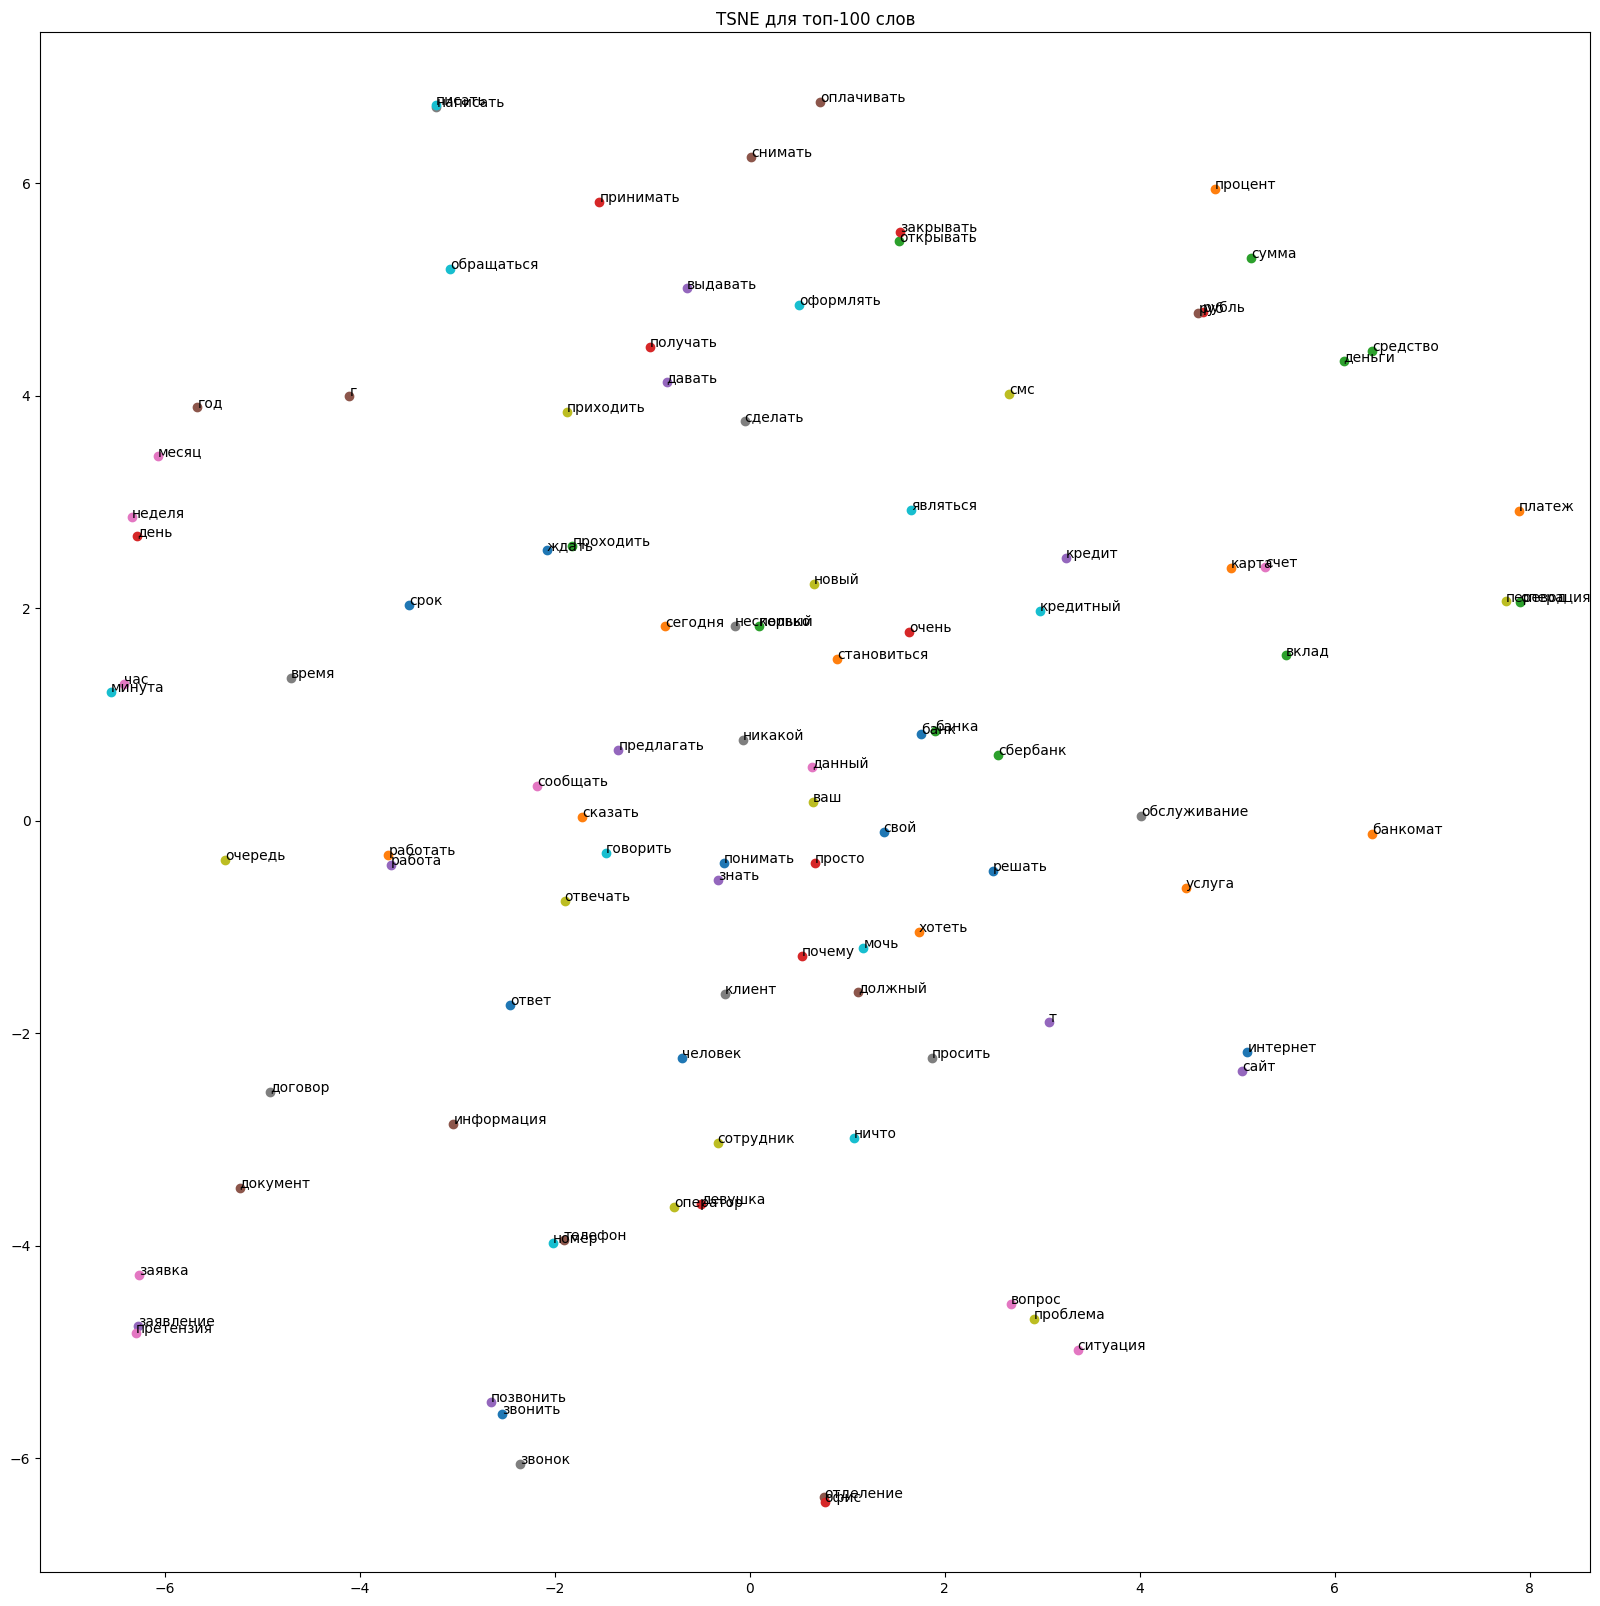

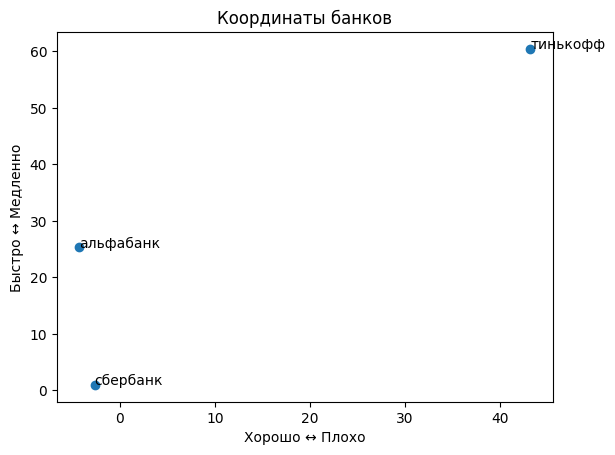

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# TSNE для топ-100 слов
top_words = model.wv.index_to_key[:100]
vectors = np.array([model.wv[word] for word in top_words])  # Преобразуем список в массив NumPy

tsne = TSNE(n_components=2, random_state=42)
projections = tsne.fit_transform(vectors)

plt.figure(figsize=(20, 20))
for i, word in enumerate(top_words):
    plt.scatter(projections[i, 0], projections[i, 1])
    plt.annotate(word, (projections[i, 0], projections[i, 1]))
plt.title('TSNE для топ-100 слов')
plt.show()

# Координаты банков по осям "хорошо-плохо" и "быстро-медленно"
axis_good_bad = model.wv['хороший'] - model.wv['плохой']
axis_fast_slow = model.wv['быстрый'] - model.wv['медленный']

bank_names = ['сбербанк', 'тинькофф', 'альфабанк']
coordinates = []
for bank in bank_names:
    vec = model.wv[bank]
    coord_good = vec.dot(axis_good_bad)
    coord_fast = vec.dot(axis_fast_slow)
    coordinates.append((coord_good, coord_fast))

# Визуализация
plt.scatter([c[0] for c in coordinates], [c[1] for c in coordinates])
for i, bank in enumerate(bank_names):
    plt.annotate(bank, (coordinates[i][0], coordinates[i][1]))
plt.xlabel('Хорошо ↔ Плохо')
plt.ylabel('Быстро ↔ Медленно')
plt.title('Координаты банков')
plt.show()

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation```
3. ```sklearn.semi_supervised.LabelSpreading```

In [ ]:
import networkx as nx
from sklearn.semi_supervised import LabelSpreading

# Убедимся, что начальные слова есть в модели
pos_words = ['хороший', 'быстрый', 'удобный', 'надежный']  # Должны быть в model.wv!
neg_words = ['плохой', 'медленный', 'очередь', 'проблема']

# Фильтруем слова, которые есть в модели
pos_words = [word for word in pos_words if word in model.wv.key_to_index]
neg_words = [word for word in neg_words if word in model.wv.key_to_index]

# Создаем граф на топ-1500 слов
words = model.wv.index_to_key[:1500]
G = nx.Graph()

# Добавляем узлы и ребра с весами (косинусная близость)
for word in words:
    G.add_node(word)
    for neighbor, similarity in model.wv.most_similar(word, topn=10):
        if neighbor in words and similarity > 0.5:  # Порог схожести
            G.add_edge(word, neighbor, weight=similarity)

# Инициализация меток
labels = np.full(len(words), -1)  # Все узлы изначально -1 (не размечены)
for i, word in enumerate(words):
    if word in pos_words:
        labels[i] = 1  # Позитивные
    elif word in neg_words:
        labels[i] = 0  # Негативные

# Матрица смежности
adj_matrix = nx.adjacency_matrix(G, weight='weight')

# Настройка LabelSpreading
label_prop = LabelSpreading(kernel='knn', n_neighbors=5, alpha=0.5, gamma=0.4)
label_prop.fit(adj_matrix, labels)

# Получаем предсказанные метки
predicted_labels = label_prop.predict(adj_matrix)

# Фильтруем результаты
positive_new = [words[i] for i, label in enumerate(predicted_labels) if label == 1]
negative_new = [words[i] for i, label in enumerate(predicted_labels) if label == 0]

print("Новые позитивные слова:", positive_new[:10])
print("Новые негативные слова:", negative_new[:10])

Новые позитивные слова: ['хороший', 'быстро', 'долг', 'сервис', 'устраивать', 'удобный', 'бывать', 'часто', 'комментарий', 'быстрый']
Новые негативные слова: ['банк', 'карта', 'деньги', 'день', 'кредит', 'отделение', 'счет', 'клиент', 'сотрудник', 'мочь']


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
